## Topic Modeling/Clustering

In [90]:
import pandas as pd
import numpy as np
import nltk
import pickle
import praw
import psaw
import datetime as dt
import re 
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from textblob import TextBlob
import operator

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from pprint import pprint

In [41]:
# Loads data from reddit data notebook
df_apple1 = pd.read_csv('Apple_com_df.csv')

## KMeans

In [42]:
# makes list of stop words
stop_words = stopwords.words('english')
# creates list of all post titles
apple_df_titles = df_apple1.Title
title_list = apple_df_titles.tolist()

# cleaning of titles
text = []
for i in range(len(title_list)):
    cleaning = re.sub('[%s]' % re.escape(string.punctuation),' ', title_list[i])
    cleaning = cleaning.lower()
    cleaning = re.sub('\w*\d\w*', ' ', cleaning)
    text.append(cleaning)

# removes stop words
stop = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]

# creates new list of cleaned titles
sub_titles = []
for sent in stop:
    joined = ' '.join(sent)
    sub_titles.append(joined)

<>:9: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \w
<ipython-input-42-7d8f8b9c6551>:9: DeprecationWarning: invalid escape sequence \w
  cleaning = re.sub('\w*\d\w*', ' ', cleaning)


In [43]:
# Fitsand transfroms cleaned titles using TdifVectorizer 
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(sub_titles)
features = vectorizer.transform(sub_titles)

In [48]:
# Uses TDIFVectorizer transformed data to run Kmeans 
kmeans = KMeans(n_clusters=19, random_state=42).fit(X)

In [105]:
# Prints out each cluster and main words
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(19):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),

Cluster 0:
 cook
 tim
 ceo
 apple
 says
 trump
 iphone
 twitter
 china
 calls
Cluster 1:
 app
 store
 apple
 ios
 new
 apps
 free
 google
 iphone
 tv
Cluster 2:
 ipad
 pro
 new
 apple
 inch
 mini
 keyboard
 iphone
 review
 computer
Cluster 3:
 mac
 pro
 mini
 apple
 new
 os
 old
 arm
 years
 time
Cluster 4:
 iphone
 apple
 se
 xs
 new
 xr
 max
 plus
 camera
 pro
Cluster 5:
 battery
 life
 iphone
 case
 xs
 replacement
 apple
 smart
 max
 psa
Cluster 6:
 watch
 apple
 series
 new
 bands
 iphone
 watchos
 life
 saved
 app
Cluster 7:
 apps
 ios
 apple
 party
 iphone
 mac
 use
 app
 ipad
 default
Cluster 8:
 macbook
 pro
 air
 inch
 new
 apple
 keyboard
 review
 vs
 touch
Cluster 9:
 ios
 beta
 releases
 apple
 iphone
 developer
 new
 public
 devices
 releasing
Cluster 10:
 daily
 thread
 tech
 support
 january
 april
 december
 august
 june
 february
Cluster 11:
 apple
 music
 tv
 new
 maps
 product
 card
 store
 iphones
 google
Cluster 12:
 like
 display
 apple
 iphone
 looks
 xdr
 oled


In [78]:
# Adds topic column to original dataframe
y = kmeans.predict(X)
y.tolist()
df_apple1['Topic'] = y 

In [93]:
# Sums teh upvote to downvote ratio for every post in a topic 
# Finds number of every topic
totl = []
counts= []
for i in range(19):
    summed = 0
    count = 0
    for j in range(len(df_apple1.Topic)):
        if y[j] == i:
            ur = df_apple1.Upvote_ratio[j]
            summed += ur
            count += 1
    totl.append(summed)
    counts.append(count)

110

In [98]:
# uses summed upvote ration and count of eveyr topic to take the average upvote ratio of ervy topic
avg = []
for i in range(19):
    avgp = totl[i]/counts[i]
    avg.append(avgp)
    

In [99]:
# created for graph
topic = []
for i in range(19):
    topic.append(i)

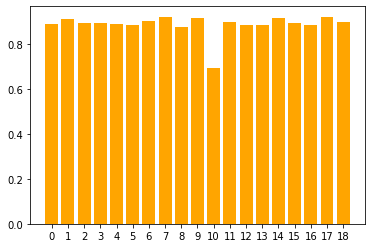

In [104]:
# Plots average upvote ratio per topic 
plt.bar(topic, avg, color = 'orange')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
plt.savefig('Avg_upvote_ratio_per topic', dpi = 300, transparent = True)

In [81]:
# Makes csv for next notebook
df_apple1.to_csv('Apple_topics_df.csv', index= False)

In [46]:
# Finds teh summed square error and shilloute coef for KMeans from 2 topics to 30 topics
SSEs = []
Sil_coefs = []
for k in range(2,30):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(X, labels, metric='euclidean'))
    SSEs.append(km.inertia_)

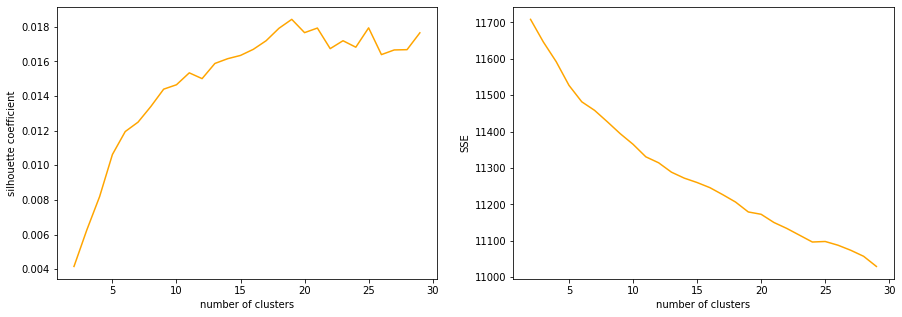

In [83]:
#PLots the list of sil coef and SSE to help determine optimal number of clusters
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,30)
ax1.plot(k_clusters, Sil_coefs,c='orange')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs, c='orange')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

## PCA

In [51]:
#Reduce kmenas resulst down to 2 dim so that we can graph results
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

In [52]:
reduced_cluster_centers

array([[ 2.09312913e-02, -1.54569580e-02],
       [ 3.86926739e-02, -3.73481109e-02],
       [-1.10600467e-01,  7.92956473e-02],
       [-4.44445384e-02,  3.52001940e-02],
       [-1.81376219e-02, -3.76142175e-02],
       [-1.25264003e-02, -2.17069335e-02],
       [ 2.30041618e-02, -3.79836391e-02],
       [ 2.88531597e-02, -2.67656704e-02],
       [-2.23655717e-01,  1.78243840e-01],
       [ 4.61198037e-02, -5.51894148e-02],
       [ 5.48393465e-01,  6.39107950e-01],
       [ 1.93654721e-02, -1.94591523e-02],
       [-1.06656966e-02, -8.94360784e-03],
       [ 9.04543931e-03,  5.34639820e-04],
       [ 3.11931456e-02, -2.77489915e-02],
       [ 1.00952882e-02, -1.18787960e-02],
       [-1.93863898e-02,  1.43709603e-02],
       [ 2.39770258e-02, -9.55812802e-03],
       [-2.38924019e-02,  9.06426708e-03]])

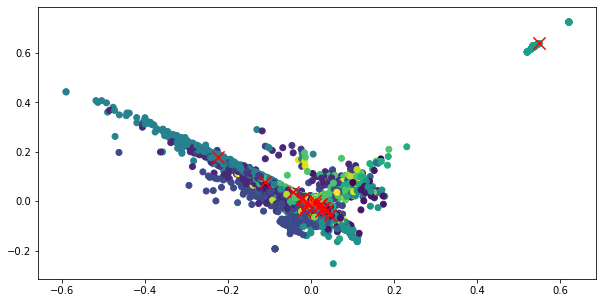

In [85]:
# Graph showing relations between clusters
plt.figure(figsize=(10,5))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='red')
plt.savefig('Topic_clusters', dpi = 300, transparent = True)

### Unused code left for later reference

## LDA

In [65]:

apple_df_titles = df_apple1.Title
title_list = apple_df_titles.tolist()

In [66]:
text = []
for i in range(len(title_list)):
    cleaning = re.sub('[%s]' % re.escape(string.punctuation),' ', title_list[i])
    cleaning = cleaning.lower()
    cleaning = re.sub('\w*\d\w*', ' ', cleaning)
    text.append(cleaning)

<>:5: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \w
<ipython-input-66-c33f81c46561>:5: DeprecationWarning: invalid escape sequence \w
  cleaning = re.sub('\w*\d\w*', ' ', cleaning)


In [67]:
def sent_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text))

print(data_words[:1])

[['here', 'is', 'everything', 'apple', 'killed', 'or', 'tried', 'to', 'kill', 'at', 'wwdc']]


In [68]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 

In [69]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [70]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [60]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['kill', 'try']]


In [71]:
data_words_nostops[1]

['apple', 'closes', 'retail', 'stores', 'dallas', 'area', 'starting', 'july']

In [72]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [73]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=19, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [74]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.171*"life" + 0.024*"craig" + 0.019*"federighi" + 0.000*"macbook" + '
  '0.000*"saved" + 0.000*"consumer" + 0.000*"victim" + 0.000*"lauderdale" + '
  '0.000*"attack" + 0.000*"interviewed"'),
 (1,
  '0.311*"ipad" + 0.086*"wwdc" + 0.074*"design" + 0.052*"come" + 0.040*"even" '
  '+ 0.035*"keynote" + 0.021*"big" + 0.020*"ui" + 0.014*"podcast" + '
  '0.009*"talks"'),
 (2,
  '0.119*"developers" + 0.093*"good" + 0.085*"keep" + 0.067*"shift" + '
  '0.046*"games" + 0.000*"night" + 0.000*"macbook" + 0.000*"work" + '
  '0.000*"seeds" + 0.000*"without"'),
 (3,
  '0.160*"store" + 0.159*"touch" + 0.079*"support" + 0.078*"id" + '
  '0.068*"feature" + 0.056*"mode" + 0.029*"face" + 0.026*"microsoft" + '
  '0.022*"dark" + 0.015*"password"'),
 (4,
  '0.716*"apple" + 0.139*"new" + 0.011*"news" + 0.010*"show" + 0.009*"talk" + '
  '0.007*"starting" + 0.006*"times" + 0.006*"future" + 0.005*"retail" + '
  '0.004*"remote"'),
 (5,
  '0.116*"like" + 0.111*"else" + 0.102*"really" + 0.075*"people" + '
  

In [76]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_nostops, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.18309848559277

Coherence Score:  0.4260701431730038


In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model_list.append(model)
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=2)


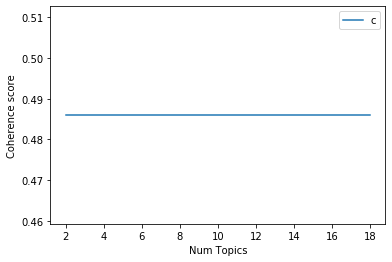

In [36]:

import matplotlib.pyplot as plt
limit=8; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()